# Introdução à Computação Visual - TP1
## Integrantes:
- Victor Henrique Silva Ribeiro - 2020022723
- Júlio Guerra Domingues - 2022431280
- Gustavo Chaves Ferreira - 2022043329


## Compressão de Imagem Grayscale usando JPEG com Matrizes de Quantização Adaptativas baseadas em Detecção de Bordas

Este notebook implementa um algoritmo de compressão de imagem grayscale baseado no JPEG, com a adição de uma técnica de quantização adaptativa que leva em consideração a presença de bordas na imagem.  Esta abordagem, que vai além do conteúdo visto em sala de aula, permite uma compressão mais eficiente, preservando detalhes em regiões de alta importância (ricas em bordas) enquanto comprime mais agressivamente regiões menos importantes.

**Etapas do algoritmo:**

1. **Divisão em Blocos:** A imagem é dividida em blocos 8x8.
2. **Detecção de Bordas (Sobel):** O operador Sobel é usado para detectar bordas em cada bloco no domínio da imagem. A soma das magnitudes do gradiente de Sobel em cada bloco é usada como medida da "força" das bordas.
3. **Classificação de Blocos e Escalares:** Os blocos são classificados continuamente em níveis de importância em uma escala de 0 a 1 (0 baixa importância, 1 alta importância) com base na força das bordas. O escalar associado a cada bloco irá controlar o nível de quantização, que será menor para blocos de alta importância e maior para blocos de baixa importância.
4. **DCT:** A Transformada Discreta do Cosseno (DCT) é aplicada a cada bloco.
5. **Quantização Adaptativa:** Uma matriz de quantização base é multiplicada pelo escalar correspondente ao nível de importância do bloco.  Os coeficientes DCT são então quantizados pela matriz resultante.
6. **Codificação Huffman:** Os coeficientes DCT quantizados são codificados usando a codificação de Huffman.
7. **Armazenamento:** Os dados comprimidos, juntamente com os escalares e a matriz de quantização base, são armazenados.
8. **Descompressão:** O processo inverso é realizado para reconstruir a imagem.


**Diferencial:**

O diferencial deste algoritmo em relação à compressão JPEG padrão é a **quantização adaptativa baseada em detecção de bordas**. Esta técnica permite uma melhor preservação dos detalhes em áreas importantes da imagem.

#### Importando bibliotecas

In [1]:
import cv2  # Manipulação de imagens
import numpy as np  # Operações matemáticas e manipulação de arrays
import matplotlib.pyplot as plt  # Visualização de imagens e gráficos
from scipy.fftpack import dct, idct  # Aplicação da DCT e IDCT
from collections import Counter  # Contagem de frequências dos valores para codificação Huffman
from collections import defaultdict  # Estruturas com valores padrão para árvores de Huffman
import heapq  # Manipulação de heaps para construir árvores de codificação Huffman

#### Função auxiliar para plotagem

In [2]:
def plotar_imagem_com_blocos(tamanho_imagem, blocos, tamanho_bloco,
                             importancias=None, delimitar_blocos=True,
                             title=""):
    """Função auxiliar que reconstrói e plota a imagem a partir dos blocos.
       Opcionalmente, plota também as importâncias dos blocos e as delimitações
       dos blocos.

      Args:
        tamanho_imagem: Tamanho da imagem original.
        blocos: Lista de blocos da imagem.
        tamanho_bloco: Tamanho dos blocos.
        importancias: (Opcional) Array com os níveis de importância normalizados de cada bloco.
        delimitar_blocos: (Opcional) Se True, plota as delimitações dos blocos.
        title: (Opcional) Título do plot.
    """
    altura, largura = tamanho_imagem
    imagem_reconstruida = np.zeros((altura, largura), dtype=np.uint8)
    niveis_colormap = None
    if importancias is not None:
      niveis_colormap = (importancias * 255).astype(np.uint8)

    idx = 0
    for i in range(0, altura, tamanho_bloco):
        for j in range(0, largura, tamanho_bloco):
          if importancias is None:
            imagem_reconstruida[i:i + tamanho_bloco, j:j + tamanho_bloco] = blocos[idx]
          else:
            ## O bloco terá uma única cor que é proporcional ao nível de importancia dele
            cor = niveis_colormap[idx]
            imagem_reconstruida[i:i + tamanho_bloco, j:j + tamanho_bloco] = np.full(
                (tamanho_bloco, tamanho_bloco), cor, dtype=np.uint8)
          idx += 1

    # Plota a imagem reconstruída
    plt.figure(figsize=(10, 10))
    plt.imshow(imagem_reconstruida, cmap='gray' if importancias is None else None)
    if importancias is not None:
      plt.colorbar(label="Importância (0=Baixa, 255=Alta)")

    if delimitar_blocos:
      # Plota as delimitações dos blocos
      for i in range(0, altura, tamanho_bloco):
          plt.axhline(y=i, color='red', linewidth=0.5)
      for j in range(0, largura, tamanho_bloco):
          plt.axvline(x=j, color='red', linewidth=0.5)

    plt.title(title)
    plt.show()

#### Função para quebrar a imagem em blocos

In [3]:
def quebrar_em_blocos(img, tamanho_bloco):
  """Quebra a imagem em blocos de tamanho fixo.

  Args:
    img: Imagem em tons de cinza.
    tamanho_bloco: Tamanho dos blocos.

  Returns:
    Lista de blocos da imagem.
  """


  blocos = []
  for i in range(0, img.shape[0], tamanho_bloco):
      for j in range(0, img.shape[1], tamanho_bloco):
          bloco = img[i:i+tamanho_bloco, j:j+tamanho_bloco]
          blocos.append(bloco)

  return blocos

#### Importando e carregando as imagens de teste

In [4]:
import requests

urls = [
    "https://github.com/juliogdomingues/computacao_visual/raw/refs/heads/main/TP1/imagens/baboon.pgm",
    "https://github.com/juliogdomingues/computacao_visual/raw/refs/heads/main/TP1/imagens/cameraman.pgm",
    "https://github.com/juliogdomingues/computacao_visual/raw/refs/heads/main/TP1/imagens/lena512.pgm",
    "https://github.com/juliogdomingues/computacao_visual/raw/refs/heads/main/TP1/imagens/unequal.pgm"
]

for url in urls:
    filename = url.split("/")[-1]
    print(f"Baixando {filename}...")
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)
    print(f"{filename} salvo com sucesso!")

Baixando baboon.pgm...
baboon.pgm salvo com sucesso!
Baixando cameraman.pgm...
cameraman.pgm salvo com sucesso!
Baixando lena512.pgm...
lena512.pgm salvo com sucesso!
Baixando unequal.pgm...
unequal.pgm salvo com sucesso!


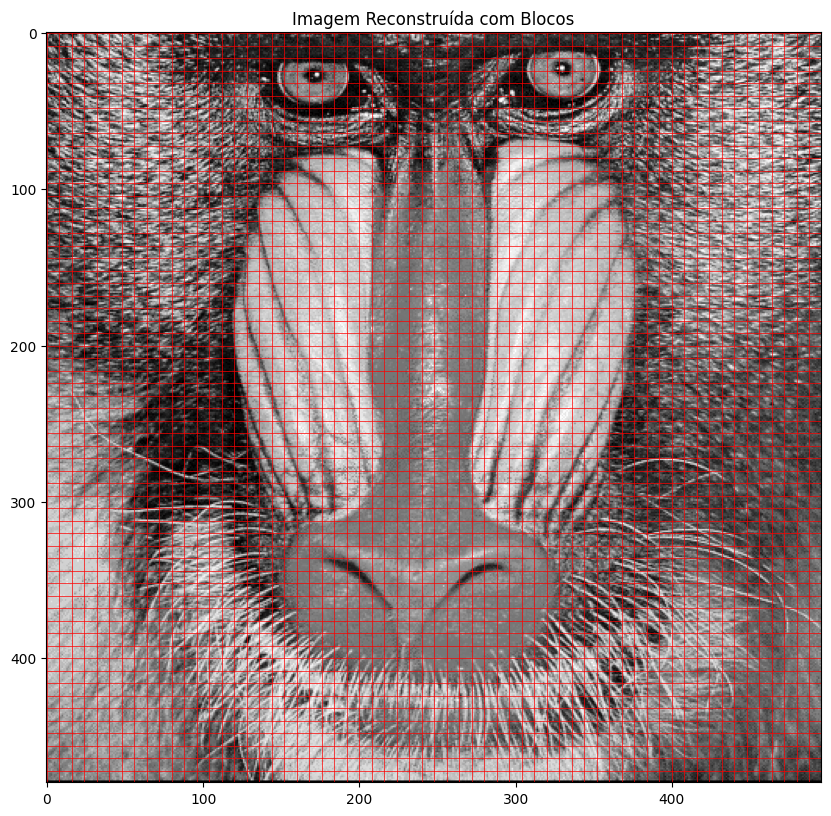

Imagem quebrada em 3720 blocos de tamanho 8


In [5]:
# Carrega a imagem
img = cv2.imread("baboon.pgm", cv2.IMREAD_GRAYSCALE)
# img = cv2.imread("cameraman.pgm", cv2.IMREAD_GRAYSCALE)
# img = cv2.imread("lena512.pgm", cv2.IMREAD_GRAYSCALE)
# img = cv2.imread("unequal.pgm", cv2.IMREAD_GRAYSCALE)

# Calcula as novas dimensões (múltiplas do tamanho do bloco)
tamanho_bloco = 8
altura_blocos = img.shape[0] // tamanho_bloco
largura_blocos = img.shape[1] // tamanho_bloco
nova_altura = altura_blocos * tamanho_bloco
nova_largura = largura_blocos * tamanho_bloco

# Corta a imagem para as novas dimensões
img = img[:nova_altura, :nova_largura]

# Divide em blocos
blocos = quebrar_em_blocos(img, tamanho_bloco)

tamanho_imagem = img.shape
plotar_imagem_com_blocos(tamanho_imagem, blocos, tamanho_bloco, title="Imagem Reconstruída com Blocos")
print(f"Imagem quebrada em {len(blocos)} blocos de tamanho {tamanho_bloco}")


#### Cálculo do gradiente Sobel do bloco para classificar o nível de importância. Segue-se normalização e plotagem da imagem.

In [6]:
def sobel(block):
    """Calcula o gradiente de Sobel do bloco.

    Args:
      block: Bloco da imagem

    Returns:
      Magnitude do gradiente de Sobel.
    """

    sobel_x = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)

    # Calcula a magnitude do gradiente
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    return magnitude

def classificar_bloco(block):
    """Classifica o bloco com base na magnitude do gradiente de Sobel.

    Args:
        block: Bloco da imagem

    Returns:
        A soma das magnitudes do gradiente de Sobel (não normalizada).
    """

    magnitude = sobel(block)
    soma_magnitudes = np.sum(magnitude)
    return soma_magnitudes


def classificar_blocos(blocos):
    """Classifica a lista de blocos e normaliza os valores de importância.

    Args:
      blocos: Lista de blocos.

    Returns:
      Uma matriz com os valores de importância normalizados para cada bloco.
    """

    importancias = []
    for block in blocos:  # Itera diretamente sobre a lista de blocos
        importancias.append(classificar_bloco(block))

    max_val = np.max(importancias) if importancias else 0  # Evita erro se a lista estiver vazia
    importancias_normalizadas = np.array(importancias) / (max_val if max_val !=0 else 1) # Evita divisão por zero
    return importancias_normalizadas, max_val

    # Encontra o valor máximo (dinâmico)
    max_val = np.max(importancias)
    # Normaliza as importâncias
    importancias_normalizadas = np.array(importancias) / max_val

    return importancias_normalizadas

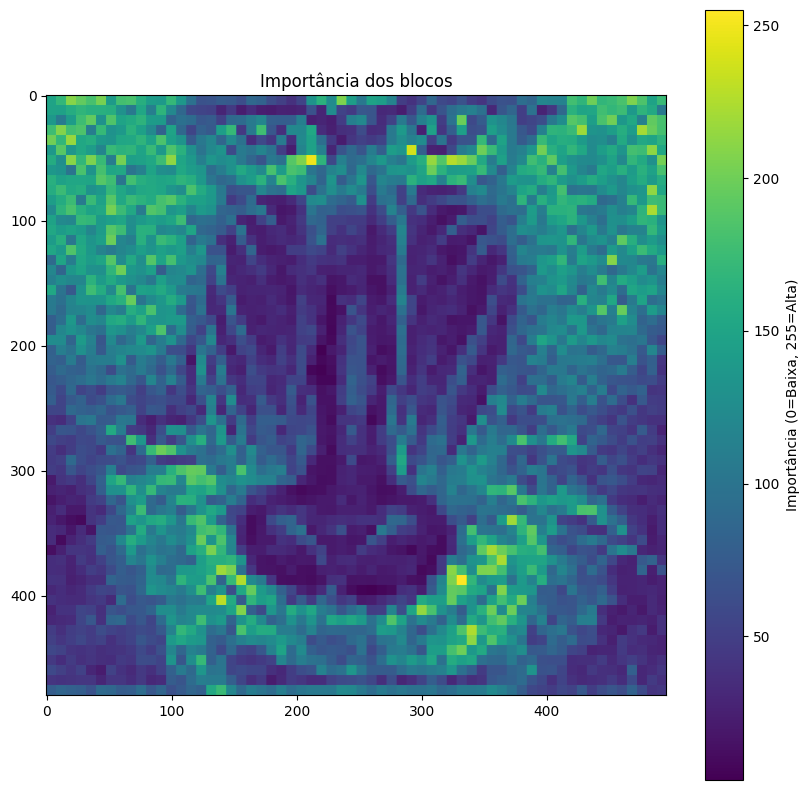

In [7]:
# Classifica os blocos e normaliza as importâncias
importancias_normalizadas, max_val = classificar_blocos(blocos)

# Plota a imagem com os blocos e as importâncias
plotar_imagem_com_blocos(img.shape, blocos, tamanho_bloco,
                         importancias_normalizadas, delimitar_blocos=False,
                         title="Importância dos blocos")

#### Aplicando a DCT em cada um dos blocos

In [8]:
def dct2(block):
    """"Calcula a DCT 2D de um bloco

    Args:
      block: Bloco da imagem.

    Returns:
      DCT 2D do bloco.
    """

    return dct(dct(block.T, norm='ortho').T, norm='ortho')

In [9]:
# Aplica a DCT aos blocos
blocos_dct = [dct2(bloco.astype(np.float32)) for bloco in blocos]

# Visualizando o primeiro bloco após aplicar a DCT
print(blocos_dct[0])

[[452.74997    37.472748   19.9483      1.5747421   4.7500105   8.094377
    6.3494368 -58.672134 ]
 [-29.504093  -31.72128    53.688885  -28.734707  -49.583073  -28.472897
  -23.876148    2.728469 ]
 [-69.657715  -18.89745    32.83148    89.94875    -5.649733  -25.154228
  -13.881726   31.632725 ]
 [-95.367165   49.526093  -66.93565   -52.16697     7.0215597  52.947807
   17.417183    1.1143627]
 [-79.25      -18.496115  -34.546997    3.0482106   7.249997   11.9464245
   22.427776   16.978228 ]
 [-88.07417   -34.29813   -25.754642   -8.8897705  54.248432  -39.20614
   -9.573987    2.3441238]
 [-16.607302   35.373413   -2.3817282 -19.508606   16.411297   31.181664
    6.668521  -19.585209 ]
 [-11.733576   -2.6091008  -9.184675  -12.345121   15.927917   14.449057
   21.421267   14.594391 ]]


#### Quantização Adaptativa dos Coeficientes DCT

##### Fator de escala máximo
Na próxima célula, definimos o fator de escala máximo, que afeta o quanto os ajustes baseados na importância de blocos influenciam na compressão.
Quando o nível de importância do bloco é menor, o fator de escala resultante aumenta, permitindo maior compressão nas regiões de baixa relevância.
Valores maiores resultam em compressão mais agressiva para blocos de baixa importância, mas maior perda de qualidade.

In [10]:
# Ajustar o max_scaling_factor
max_scaling_factor = 1.5

##### Base da matriz de quantização

Na próxima célula, modificamos a matriz de quantização para controlar a granularidade com que os coeficientes da DCT são quantizados. Aumento dos valores reduz a precisão dos coeficientes da DCT, levando a maior compressão e perda de detalhes nas frequências altas (texturas).

In [11]:
# Definindo a matriz de quantização base (matriz padrão do JPEG)
quantization_matrix_base = np.array([
    [16, 11, 10, 16, 24,  40,  51,  61],
    [12, 12, 14, 19, 26,  58,  60,  55],
    [14, 13, 16, 24, 40,  57,  69,  56],
    [14, 17, 22, 29, 51,  87,  80,  62],
    [18, 22, 37, 56, 68, 109, 103,  77],
    [24, 35, 55, 64, 81, 104, 113,  92],
    [49, 64, 78, 87,103, 121, 120, 101],
    [72, 92, 95, 98,112, 100, 103,  99],
])

# Modificar a matriz de quantização base
quantization_matrix_base = (quantization_matrix_base / 4).astype(np.float32)

In [12]:
def get_adjusted_quantization_matrix(quantization_matrix_base, importance_scalar, max_scaling_factor):
    # Ajusta a matriz de quantização com base na importância
    scaling = 1 + (1 - importance_scalar) * (max_scaling_factor - 1)
    adjusted_quantization_matrix = quantization_matrix_base * scaling
    return adjusted_quantization_matrix

# Aplica a raiz quadrada às importâncias normalizadas
importancias_ajustadas = np.sqrt(importancias_normalizadas)

def quantize_block(dct_block, quantization_matrix):
    # Quantiza o bloco DCT
    return np.round(dct_block / quantization_matrix).astype(np.int32)

# Quantiza os coeficientes DCT de cada bloco usando as importâncias ajustadas
blocos_quantizados = []
for idx, dct_block in enumerate(blocos_dct):
    importance_scalar = importancias_ajustadas[idx]
    adjusted_quantization_matrix = get_adjusted_quantization_matrix(
        quantization_matrix_base, importance_scalar, max_scaling_factor)
    quantized_block = quantize_block(dct_block, adjusted_quantization_matrix)
    blocos_quantizados.append(quantized_block)

#### Codificação Huffman dos Coeficientes Quantizados

Na próxima célula, calculamos a entropia da imagem como "proxy" para a compressibilidade. Em seguida, implementamos a codificação Huffman para comprimir os coeficientes quantizados, reduzindo o número de bits necessários para armazená-los.

In [13]:
def calcEntropy(data):
    # Calcula a entropia dos dados
    unique, counts = np.unique(data, return_counts=True)
    probs = counts / counts.sum()
    ent = -np.sum(probs * np.log2(probs))
    return ent # Retorna a entropia em bits por símbolo

def encode(symb2freq):
    # Codifica os símbolos usando Huffman
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0]+hi[0]] + lo[1:] + hi[1:])
    codebook = {}
    for p in heapq.heappop(heap)[1:]:
        codebook[p[0]] = p[1]
    return codebook

# Agrupa todos os coeficientes quantizados
quantized_coefficients = np.hstack([block.flatten() for block in blocos_quantizados])

# Calcula a entropia dos coeficientes quantizados
entropia = calcEntropy(quantized_coefficients)
print(f"Entropia dos coeficientes quantizados: {entropia:.3f} bits por símbolo")

# Cria o dicionário de frequências dos símbolos
unique_vals, counts = np.unique(quantized_coefficients, return_counts=True)
total_symbols = len(quantized_coefficients)
symb2freq = dict(zip(unique_vals, counts / total_symbols))

# Realiza a codificação Huffman
huff = encode(symb2freq)

# Calcula o número total de bits após a codificação
nbits = sum(len(huff[symbol]) * count for symbol, count in zip(unique_vals, counts))

bpp = nbits / total_symbols  # bits por símbolo
print(f"Média de bits por símbolo após codificação Huffman: {bpp:.3f} bits por símbolo")
print(f"Entropia: {entropia:.3f} bits por símbolo")
print(f"Eficiência de compressão: {entropia / bpp:.3f}")

print("\nSímbolo\tProbabilidade\tCódigo Huffman")
for symbol in sorted(huff, key=lambda s: symb2freq[s], reverse=True):
    print(f"{symbol}\t{symb2freq[symbol]:.6f}\t{huff[symbol]}")

Entropia dos coeficientes quantizados: 3.224 bits por símbolo
Média de bits por símbolo após codificação Huffman: 3.233 bits por símbolo
Entropia: 3.224 bits por símbolo
Eficiência de compressão: 0.997

Símbolo	Probabilidade	Código Huffman
0	0.483934	0
1	0.119741	110
-1	0.118490	100
-2	0.037697	11101
2	0.037500	11100
3	0.020434	111110
-3	0.020018	111101
4	0.013168	101010
-4	0.012802	101001
-5	0.009514	1011111
5	0.009341	1011110
-6	0.007321	1011000
6	0.007321	1011001
-7	0.005738	11111110
7	0.005717	11111101
8	0.004809	11110000
-8	0.004645	10111011
-9	0.004024	10110111
9	0.003948	10110101
10	0.003289	10101100
-10	0.003150	10100010
-11	0.002907	111111111
11	0.002827	111111001
12	0.002537	111100101
-12	0.002428	111100011
-13	0.002201	101110011
13	0.001970	101101100
-14	0.001827	101011111
14	0.001743	101011100
15	0.001668	101000111
-15	0.001584	101000011
-16	0.001386	1111110001
16	0.001327	1111001110
-17	0.001222	1111001000
17	0.001151	1011101010
-18	0.001092	1011100101
18	0.001033	10111000

#### Descompressão e Reconstrução da Imagem

Essa parte do código trata da descompressão dos dados para reconstruir a imagem comprimida. O processo envolve a aplicação da Transformada Discreta do Cosseno Inversa (IDCT) em cada bloco quantizado e a reconstrução da imagem a partir desses blocos.

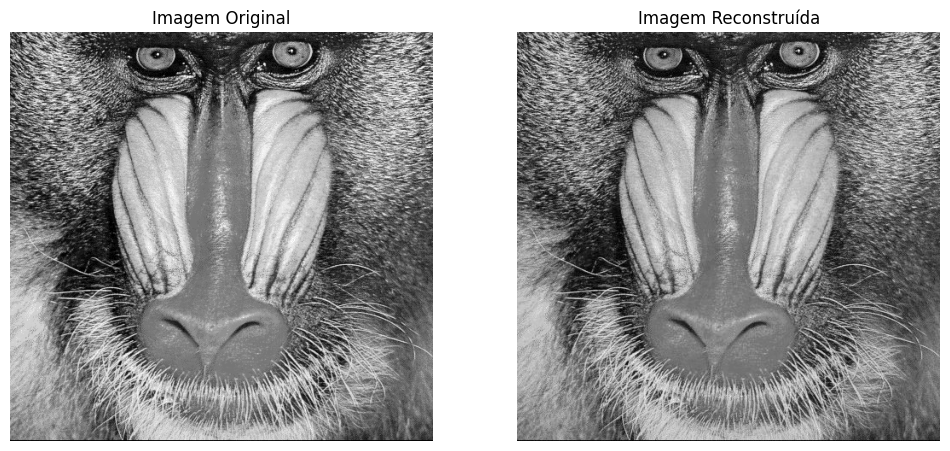

In [14]:
def idct2(block):
    # Calcula a IDCT 2D de um bloco
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Reconstroi os blocos da imagem usando as importâncias ajustadas
blocos_reconstruidos = []
for idx, quantized_block in enumerate(blocos_quantizados):
    importance_scalar = importancias_ajustadas[idx]
    adjusted_quantization_matrix = get_adjusted_quantization_matrix(
        quantization_matrix_base, importance_scalar, max_scaling_factor)
    dequantized_block = quantized_block * adjusted_quantization_matrix
    reconstructed_block = idct2(dequantized_block)
    reconstructed_block = np.clip(reconstructed_block, 0, 255)
    blocos_reconstruidos.append(reconstructed_block.astype(np.uint8))

def reconstruir_imagem(tamanho_imagem, blocos, tamanho_bloco):
    # Reconstroi a imagem a partir dos blocos
    altura, largura = tamanho_imagem
    imagem_reconstruida = np.zeros((altura, largura), dtype=np.uint8)
    idx = 0
    for i in range(0, altura, tamanho_bloco):
        for j in range(0, largura, tamanho_bloco):
            imagem_reconstruida[i:i + tamanho_bloco, j:j + tamanho_bloco] = blocos[idx]
            idx +=1
    return imagem_reconstruida

# Reconstroi a imagem completa
imagem_reconstruida = reconstruir_imagem(tamanho_imagem, blocos_reconstruidos, tamanho_bloco)

# Plota as imagens original e reconstruída
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagem_reconstruida, cmap='gray')
plt.title("Imagem Reconstruída")
plt.axis('off')

plt.show()

#### Avaliação da Qualidade da Reconstrução

In [15]:
# Calcula o MSE e o PSNR
def compute_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

def compute_psnr(mse):
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

mse = compute_mse(img, imagem_reconstruida)
psnr = compute_psnr(mse)
print(f"MSE: {mse:.2f}")
print(f"PSNR: {psnr:.2f} dB")

MSE: 27.09
PSNR: 33.80 dB


#### Cálculo da Taxa de Compressão

In [16]:
# Calcula o tamanho da imagem original em bits
altura, largura = img.shape
tamanho_original_bits = altura * largura * 8  # 8 bits por pixel para imagem em escala de cinza

# O tamanho dos dados comprimidos é dado por nbits (já calculado anteriormente)

# Calcula a taxa de compressão
taxa_compressao = tamanho_original_bits / nbits

print(f"\nTamanho da imagem original: {tamanho_original_bits} bits")
print(f"Tamanho dos dados comprimidos: {nbits} bits")
print(f"Taxa de compressão: {taxa_compressao:.2f}:1")


Tamanho da imagem original: 1904640 bits
Tamanho dos dados comprimidos: 769686 bits
Taxa de compressão: 2.47:1


#### Visualização da Diferença Absoluta entre as Imagens

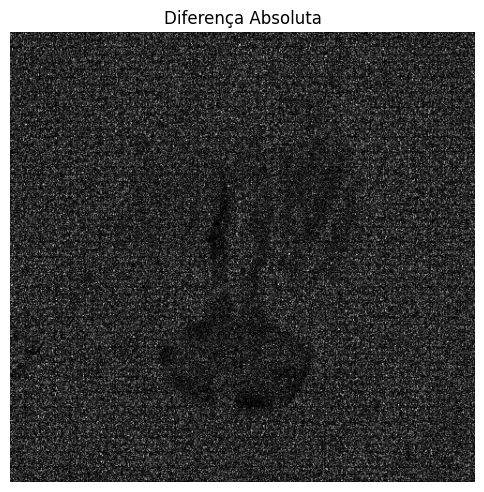

In [17]:
# Calcula a diferença absoluta entre as imagens
diferenca = cv2.absdiff(img, imagem_reconstruida)

# Plota a diferença
plt.figure(figsize=(6, 6))
plt.imshow(diferenca, cmap='gray')
plt.title("Diferença Absoluta")
plt.axis('off')
plt.show()

## Resultados e Discussão


Resumo dos resultados:

| Imagem | PSNR | Taxa de Compressão
| ------------- | ------------- | ------------- |
| Baboon | 33.80  | 2.47:1 |
| Cameraman | 36.49 | 3.31:1 |
| Lena512 | 39.20 | 4.02:1 |
| Unequal | 45.46 | 5.47:1 |

O algoritmo implementado conseguiu uma compressão considerável das imagens de teste, com taxa de compressão sempre superior a 2:1. A qualidade da imagem reconstruída permanece alta, evidenciada pelo PSNR superior a 33 dB, indicando que a maioria dos detalhes importantes foram preservados.

A heterogeneidade dos resultados para as diferentes imagens demonstra o quanto sua eficiência pode variar de acordo com características da imagem. De forma geral, percebe-se maior compressão e maior PSNR para imagens com mais regiões homogêneas. Para imagens com texturas complexas e alta variabilidade tonal, a compressão é menos eficiente e a perda de qualidade é mais perceptível.

Ressalta-se que o equilíbrio entre compressão e qualidade pode ser ajustado com a modificação de alguns parâmetros. No presente trabalho, especificamente, foram selecionados valores arbitrários para o fator de escala máximo na quantização e a matriz de quantização, de forma a alcançar os resultados esperados.

A quantização adaptativa baseada em detecção de bordas mostrou-se eficaz em manter a qualidade nas áreas mais importantes da imagem. A eficiência da codificação Huffman está próxima da entropia teórica dos dados, demonstrando uma boa compactação sem perda adicional significativa.


### Outras alternativas testadas:

1. Técnicas de pré-processamento

* Tanto filtro gaussiano e da média resultaram em degradação do PSNR.


2. Tranformadas

* Transformada do Seno (DST):

	•	Objetivo: Substituir a DCT por uma alternativa matemática.

	•	Problema: Piorou a qualidade reconstruída, ficando abaixo do limite aceitável.


* Transformada Rápida de Fourier (FFT):

	•	Objetivo: Representar a imagem no domínio da frequência com outra abordagem.

	•	Problema: Exige o armazenamento de fase e espectro de frequências, comprometendo a eficiência da compressão.

* Transformada Wavelet:

	•	Objetivo: Usar uma técnica que divide a imagem de forma hierárquica em diferentes frequências e localizações.

	•	Problema: Não é compatível com o esquema atual de quantização baseado na matriz padrão do JPEG.
  
3. Codificação Sem Perdas

* Codificação Aritmética:

	•	Objetivo: Substituir Huffman para alcançar maior compressão.

	•	Problema: Enfrentou limitações de precisão numérica para arquivos grandes, inviabilizando o método.

* Codificação por Comprimento de Corrida (RLE):

	•	Objetivo: Compactar sequências de valores repetidos, como zeros.

	•	Problema: Só funciona bem em imagens com regiões homogêneas, o que não é o caso para a maioria das imagens (coeficientes DCT resultam em valores pequenos, mas não repetitivos).

* Codificação LZW (Lempel-Ziv-Welch):

	•	Objetivo: Usar um método eficiente para compressão sem perdas.

	•	Problema: Aumentou o tamanho do arquivo comprimido, indicando que não é adequada para os coeficientes DCT.

#### Opcional: Comparação com JPEG padrão

##### Compressão da Imagem usando JPEG Padrão

In [18]:
# Compressão da imagem usando o codec JPEG padrão do OpenCV
# Define parâmetros de compressão (qualidade padrão de 95)
parametros = [int(cv2.IMWRITE_JPEG_QUALITY), 95]

# Codifica a imagem em formato JPEG e armazena em memória
resultado, img_comprimida = cv2.imencode('.jpg', img, parametros)

# Verifica se a compressão foi bem-sucedida
if resultado:
    print("Compressão JPEG padrão realizada com sucesso.")
else:
    print("Erro na compressão JPEG padrão.")

Compressão JPEG padrão realizada com sucesso.


##### Cálculo do Tamanho dos Dados Comprimidos

In [19]:
# Calcula o tamanho dos dados comprimidos em bits
tamanho_comprimido_jpeg = len(img_comprimida.tobytes()) * 8  # Converte bytes para bits

print(f"Tamanho dos dados comprimidos (JPEG padrão): {tamanho_comprimido_jpeg} bits")

Tamanho dos dados comprimidos (JPEG padrão): 1167416 bits


##### Reconstrução da Imagem a partir da Compressão JPEG

In [20]:
# Decodifica a imagem comprimida em JPEG
img_reconstruida_jpeg = cv2.imdecode(img_comprimida, cv2.IMREAD_GRAYSCALE)

# Verifica se a decodificação foi bem-sucedida
if img_reconstruida_jpeg is not None:
    print("Reconstrução da imagem a partir do JPEG realizada com sucesso.")
else:
    print("Erro na reconstrução da imagem a partir do JPEG.")

Reconstrução da imagem a partir do JPEG realizada com sucesso.


##### Cálculo do PSNR para o JPEG Padrão

In [21]:
# Calcula o MSE e o PSNR para a imagem comprimida em JPEG
mse_jpeg = compute_mse(img, img_reconstruida_jpeg)
psnr_jpeg = compute_psnr(mse_jpeg)
print(f"MSE (JPEG padrão): {mse_jpeg:.2f}")
print(f"PSNR (JPEG padrão): {psnr_jpeg:.2f} dB")

MSE (JPEG padrão): 3.83
PSNR (JPEG padrão): 42.30 dB


##### Cálculo da Taxa de Compressão para o JPEG Padrão

In [22]:
# Calcula a taxa de compressão para o JPEG padrão
taxa_compressao_jpeg = tamanho_original_bits / tamanho_comprimido_jpeg
print(f"Taxa de compressão (JPEG padrão): {taxa_compressao_jpeg:.2f}:1")

Taxa de compressão (JPEG padrão): 1.63:1


##### Comparação dos Resultados

In [23]:
# Exibe os resultados obtidos pelos dois métodos
print("\nComparação dos resultados:")
print(f"PSNR (método adaptativo): {psnr:.2f} dB")
print(f"PSNR (JPEG padrão): {psnr_jpeg:.2f} dB")
print(f"Taxa de compressão (método adaptativo): {taxa_compressao:.2f}:1")
print(f"Taxa de compressão (JPEG padrão): {taxa_compressao_jpeg:.2f}:1")


Comparação dos resultados:
PSNR (método adaptativo): 33.80 dB
PSNR (JPEG padrão): 42.30 dB
Taxa de compressão (método adaptativo): 2.47:1
Taxa de compressão (JPEG padrão): 1.63:1


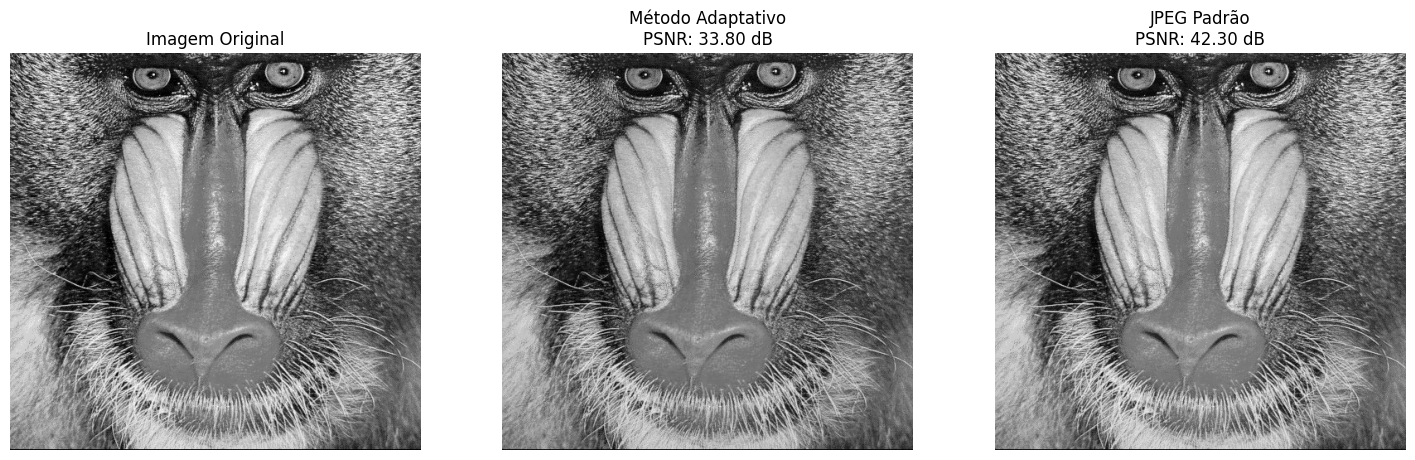

In [24]:
# Plota as imagens reconstruídas pelos dois métodos
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(imagem_reconstruida, cmap='gray')
plt.title(f"Método Adaptativo\nPSNR: {psnr:.2f} dB")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_reconstruida_jpeg, cmap='gray')
plt.title(f"JPEG Padrão\nPSNR: {psnr_jpeg:.2f} dB")
plt.axis('off')

plt.show()